<h1 align="center" style="font-variant: small-caps;"> 
Savoring Sentiments: Predicting Restaurant Recipe Ratings through Sentiment Analysis
<h3 align="center" style="font-variant: small-caps;"> Machine Learning Capstone Project
<h4 align="center" style="font-variant: small-caps;"> IIT Madras
<h5 align="center" style="font-variant: small-caps;"> Jan-Apr 2024

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)


import matplotlib.pyplot as plt
import seaborn as sns

# Reading the data

In [2]:
df = pd.read_csv('train.csv')
df1 = pd.read_csv('test.csv')

## Assigning training and test data

In [3]:
X_train = df.drop("Rating",axis=1)
y_train = df['Rating']
X_test = df1

# Feature Engineering

## Exploratory Data Analysis

In [4]:
# Identifying the datatypes of each feature

df.dtypes

ID                    int64
RecipeNumber          int64
RecipeCode            int64
RecipeName           object
CommentID            object
UserID               object
UserName             object
UserReputation        int64
CreationTimestamp     int64
ReplyCount            int64
ThumbsUpCount         int64
ThumbsDownCount       int64
Rating                int64
BestScore             int64
Recipe_Review        object
dtype: object

In [5]:
# Statistics about likes-dislikes of recipes by user

print('Maximum number of ThumbsDown received for one recipe: ',X_train.ThumbsDownCount.max())
print('Maximum number of ThumbsUp received for one recipe: ',X_train.ThumbsUpCount.max())

Maximum number of ThumbsDown received for one recipe:  126
Maximum number of ThumbsUp received for one recipe:  80


(array([11816.,  1204.]),
 array([0., 1., 2.]),
 <BarContainer object of 2 artists>)

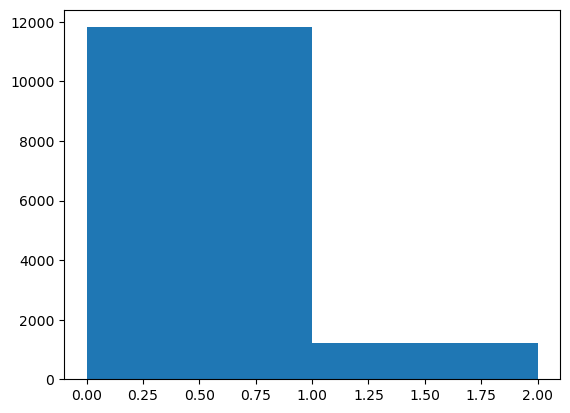

In [6]:
# ThumbsDownCount Histogram

plt.hist(X_train.ThumbsDownCount,bins=[0,1,2])

(array([10582.,  1768.]),
 array([0., 1., 2.]),
 <BarContainer object of 2 artists>)

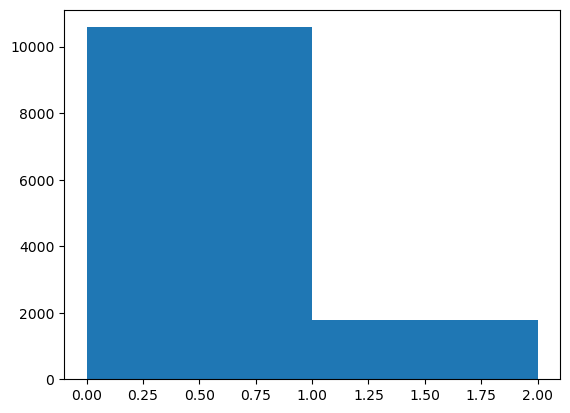

In [7]:
# ThumbsDownCount Histogram

plt.hist(X_train.ThumbsUpCount,bins=[0,1,2])

In [8]:
# Segregating the numerical and categorical features

num_data = df.select_dtypes(include=['int64'])
cat_data = df.select_dtypes(include=['object'])
cat_data_test = df1.select_dtypes(include=['object'])
num_data_test = df1.select_dtypes(include=['object'])

In [9]:
# Information about the target variable

print('Statistics about Rating\n',y_train.describe())
print('\nUnique values : ',y_train.nunique())
print('\nValue Counts : ')
print(y_train.value_counts())

Statistics about Rating
 count    13636.000000
mean         4.288721
std          1.544839
min          0.000000
25%          5.000000
50%          5.000000
75%          5.000000
max          5.000000
Name: Rating, dtype: float64

Unique values :  6

Value Counts : 
Rating
5    10371
0     1272
4     1241
3      368
1      210
2      174
Name: count, dtype: int64


<AxesSubplot: xlabel='Rating', ylabel='Count'>

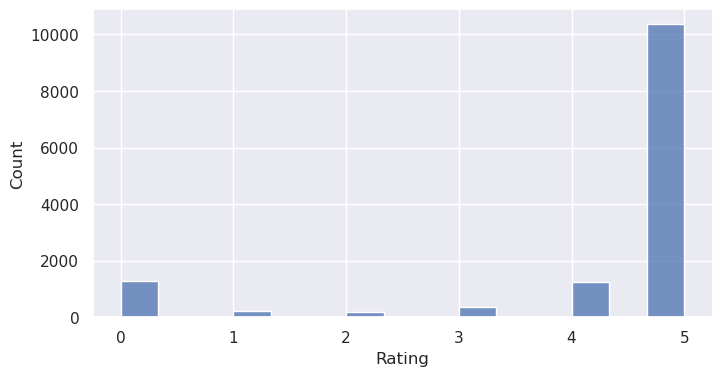

In [10]:
sns.set(rc={'figure.figsize':(8,4)})
sns.histplot(df.Rating, kde=False)

The mode of the distribution of 'Rating' is 5, and the least frequency of rating is 2.

## Handling missing values

In [11]:
# Detecting the presence of any missing values in the dataset

X_train.isna().sum()

ID                   0
RecipeNumber         0
RecipeCode           0
RecipeName           0
CommentID            0
UserID               0
UserName             0
UserReputation       0
CreationTimestamp    0
ReplyCount           0
ThumbsUpCount        0
ThumbsDownCount      0
BestScore            0
Recipe_Review        2
dtype: int64

In [12]:
# replacing all missing values in 'Recipe_Review' with 'unknown'

X_train['Recipe_Review']=X_train['Recipe_Review'].replace(np.nan,"unknown")

In [13]:
# Rechecking whether all missing values are handled

X_train.isna().sum()

ID                   0
RecipeNumber         0
RecipeCode           0
RecipeName           0
CommentID            0
UserID               0
UserName             0
UserReputation       0
CreationTimestamp    0
ReplyCount           0
ThumbsUpCount        0
ThumbsDownCount      0
BestScore            0
Recipe_Review        0
dtype: int64

In [14]:
# Detecting the presence of missing values in the target variable

y_train.isna().sum()

0

In [15]:
# Detecting the presence of missing values in the test dataset

X_test.isna().sum()

ID                   0
RecipeNumber         0
RecipeCode           0
RecipeName           0
CommentID            0
UserID               0
UserName             0
UserReputation       0
CreationTimestamp    0
ReplyCount           0
ThumbsUpCount        0
ThumbsDownCount      0
BestScore            0
Recipe_Review        0
dtype: int64

## Correlation 

Checking the correlation of numeric features with respect to the target variable

In [16]:
num_data.Rating.describe()

count    13636.000000
mean         4.288721
std          1.544839
min          0.000000
25%          5.000000
50%          5.000000
75%          5.000000
max          5.000000
Name: Rating, dtype: float64

In [17]:
num_data.columns

Index(['ID', 'RecipeNumber', 'RecipeCode', 'UserReputation',
       'CreationTimestamp', 'ReplyCount', 'ThumbsUpCount', 'ThumbsDownCount',
       'Rating', 'BestScore'],
      dtype='object')

<AxesSubplot: title={'center': 'Correlation of numeric features with respect to Rating'}>

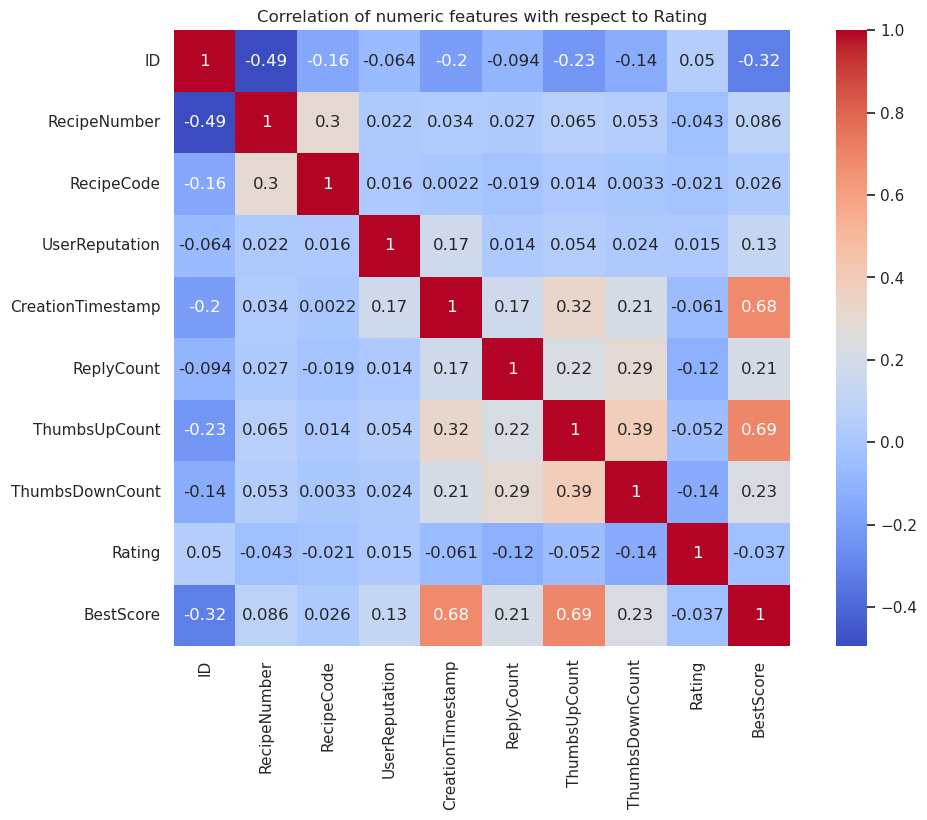

In [18]:
# Visualizing the correlation between the numerical features of the given data

import matplotlib.pyplot as plt
import seaborn as sns

correlation = num_data.corr()

plt.subplots(figsize=(12,8))
plt.title('Correlation of numeric features with respect to Rating')
sns.heatmap(correlation,square=True,vmax=1.0,cmap='coolwarm',annot=True)

In [19]:
# Using correlation to understand the importance of features with respect to Rating

print(correlation['Rating'].sort_values(ascending=False),'\n')

Rating               1.000000
ID                   0.049673
UserReputation       0.015038
RecipeCode          -0.020714
BestScore           -0.036719
RecipeNumber        -0.043127
ThumbsUpCount       -0.051752
CreationTimestamp   -0.061216
ReplyCount          -0.124860
ThumbsDownCount     -0.142273
Name: Rating, dtype: float64 



# Feature Selection

In [20]:
# importing all necessary libraries

from sklearn.preprocessing import OrdinalEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import MinMaxScaler
from sklearn.compose import ColumnTransformer

from sklearn.compose import make_column_selector as selector
from sklearn.pipeline import Pipeline

import matplotlib.pyplot as plt
import seaborn as sns

In [21]:
# Using Column Transformer for applying scaling and encoding to specific columns

column_trans = ColumnTransformer(transformers=[('numerical', MinMaxScaler(), selector(dtype_exclude="object")),
        ('categorical', OrdinalEncoder(), selector(dtype_include="object"))],remainder='drop')

In [22]:
# Using a Random Forest Classifier for feature importance

clf = RandomForestClassifier(random_state=42, n_jobs=6, class_weight='balanced')

pipeline = Pipeline([('prep',column_trans),('clf', clf)])

In [23]:
pipeline.fit(X_train, y_train)

Pipeline(steps=[('prep',
                 ColumnTransformer(transformers=[('numerical', MinMaxScaler(),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x784ce72d4b60>),
                                                 ('categorical',
                                                  OrdinalEncoder(),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x784ce6a50380>)])),
                ('clf',
                 RandomForestClassifier(class_weight='balanced', n_jobs=6,
                                        random_state=42))])

In [24]:
pipeline['clf'].feature_importances_

array([0.12026882, 0.06881737, 0.06930947, 0.00934795, 0.09482167,
       0.00401466, 0.02187323, 0.04797646, 0.02959167, 0.06922188,
       0.11305184, 0.12342223, 0.11265213, 0.1156306 ])

In [25]:
feat_list = []
targets = X_train.columns
total_importance = 0

# Printing the name and gini importance of each feature

for feature in zip(targets, pipeline['clf'].feature_importances_):
    feat_list.append(feature)
    total_importance += feature[1]

included_feats = []

# Printing the name and gini importance of each feature

for feature in zip(targets, pipeline['clf'].feature_importances_):
    if feature[1] > 0.05:
        included_feats.append(feature[0])

print("Cumulative Importance =", total_importance,'\n')

# creating DataFrame using the calculated data

df_imp = pd.DataFrame(feat_list, columns =['FEATURE', 'IMPORTANCE']).sort_values(by='IMPORTANCE', ascending=False)
df_imp['CUMSUM'] = df_imp['IMPORTANCE'].cumsum()
df_imp

Cumulative Importance = 1.0 



,FEATURE,IMPORTANCE,CUMSUM
11,ThumbsDownCount,0.123422,0.123422
0,ID,0.120269,0.243691
13,Recipe_Review,0.115631,0.359322
10,ThumbsUpCount,0.113052,0.472373
12,BestScore,0.112652,0.585026
4,CommentID,0.094822,0.679847
2,RecipeCode,0.069309,0.749157
9,ReplyCount,0.069222,0.818379
1,RecipeNumber,0.068817,0.887196
7,UserReputation,0.047976,0.935172


In [26]:
print('Most Important Features:')
print(included_feats)
print('Number of Included Features =', len(included_feats))

Most Important Features:
['ID', 'RecipeNumber', 'RecipeCode', 'CommentID', 'ReplyCount', 'ThumbsUpCount', 'ThumbsDownCount', 'BestScore', 'Recipe_Review']
Number of Included Features = 9


In [27]:
X_train.dtypes

ID                    int64
RecipeNumber          int64
RecipeCode            int64
RecipeName           object
CommentID            object
UserID               object
UserName             object
UserReputation        int64
CreationTimestamp     int64
ReplyCount            int64
ThumbsUpCount         int64
ThumbsDownCount       int64
BestScore             int64
Recipe_Review        object
dtype: object

In [28]:
# filtering the names of important numeric columns necessary based on the correlation coefficients

numeric = ["ID","RecipeNumber","RecipeCode","ReplyCount","ThumbsDownCount","ThumbsUpCount","BestScore"]

In [29]:
# filtering the names of important categorical columns necessary based on the correlation coefficients

categorical = ["RecipeName"]

In [30]:
# filtering the names of important text information columns necessary based on the correlation coefficients

text = "Recipe_Review"

# 4. Data Preprocessor

In [31]:
#Importing required libraries for pipelines

from sklearn.pipeline import Pipeline

In [32]:
# numerical preprocessing pipeline

# from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
numeric_preprocessor = Pipeline(steps=[('scaler',MinMaxScaler())])

In [33]:
# text preprocessing pipeline

from sklearn.feature_extraction.text import TfidfVectorizer
text_preprocessor = Pipeline(steps=[('tfidf',TfidfVectorizer(max_features=5000))])

In [34]:
# categorical preprocessing pipeline

from sklearn.preprocessing import OrdinalEncoder
categorical_preprocessor = Pipeline(steps=[('ohc',OrdinalEncoder())])

In [35]:
included_feats

['ID',
 'RecipeNumber',
 'RecipeCode',
 'CommentID',
 'ReplyCount',
 'ThumbsUpCount',
 'ThumbsDownCount',
 'BestScore',
 'Recipe_Review']

In [36]:
# Filtering out the required important features

# X_Train = X_train[['RecipeName','UserReputation','ThumbsUpCount','ThumbsDownCount','Recipe_Review']]
# X_Test = X_test[['RecipeName','UserReputation','ThumbsUpCount','ThumbsDownCount','Recipe_Review']]

X_Train = X_train[['ID','RecipeNumber','RecipeCode','RecipeName','ReplyCount','ThumbsDownCount','ThumbsUpCount','BestScore','Recipe_Review']]
X_Test = X_test[['ID','RecipeNumber','RecipeCode','RecipeName','ReplyCount','ThumbsDownCount','ThumbsUpCount','BestScore','Recipe_Review']]

In [37]:
print('Text:',text)
print('Numeric:',numeric)
print('Categorical:',categorical)

Text: Recipe_Review
Numeric: ['ID', 'RecipeNumber', 'RecipeCode', 'ReplyCount', 'ThumbsDownCount', 'ThumbsUpCount', 'BestScore']
Categorical: ['RecipeName']


In [38]:
# text = 'Recipe_Review'
# numeric = ["ThumbsUpCount","ThumbsDownCount","UserReputation"]
# categorical = ["RecipeName"]

In [39]:
# combining preprocessing techniques

from sklearn.compose import ColumnTransformer
preprocessor = ColumnTransformer([("categorical",categorical_preprocessor,categorical),
                                    ("numerical",numeric_preprocessor,numeric),
                                     ("text",text_preprocessor,text)])

In [40]:
preprocessor

ColumnTransformer(transformers=[('categorical',
                                 Pipeline(steps=[('ohc', OrdinalEncoder())]),
                                 ['RecipeName']),
                                ('numerical',
                                 Pipeline(steps=[('scaler', MinMaxScaler())]),
                                 ['ID', 'RecipeNumber', 'RecipeCode',
                                  'ReplyCount', 'ThumbsDownCount',
                                  'ThumbsUpCount', 'BestScore']),
                                ('text',
                                 Pipeline(steps=[('tfidf',
                                                  TfidfVectorizer(max_features=5000))]),
                                 'Recipe_Review')])

# Models

## Logistic Regression Model

In [41]:
# importing necessary libraries

# from sklearn.model_selection import RandomizedSearchCV
# from sklearn.linear_model import LogisticRegression


# param_grid_1 = [
#     {
#         'penalty':['l1','l2'],
#         'max_iter':[2500,5000]
#     }
# ]


# Applying RandomizedSearchCV on LogisticRegression for Hyperparameter-Tuning
# logModel = LogisticRegression()
# clf = RandomizedSearchCV(logModel, param_grid_1,cv=5)


# Using pipeline to sequentially line up the proceedings
# pipe = Pipeline(steps=[('preprocessor',preprocessor),('classifier',clf)])

In [42]:
# pipe

In [43]:
# Fitting the dataset into the pipeline
# pipe.fit(X_Train, y_train)


# Prediciting the target value using the test dataset
# y_pred = pipe.predict(X_Test)

In [44]:
# y_pred

    Accuracy of the model

In [45]:
# y0 = pipe.predict(X_Train)

# from sklearn.metrics import accuracy_score

# result = accuracy_score(y0, y_train)
# print('Accuracy Score of Logistic Regression Model is : ', result*100)

**Accuracy Score** of Logistic Regression Model is :  80.66881783514226

    Classification Report

In [46]:
# from sklearn.metrics import classification_report

# cr = classification_report(y0, y_train)
# print(cr)

**Classification Report**

precision    recall  f1-score   support

           0       0.24      0.75      0.37       413
           1       0.26      0.85      0.40        65
           2       0.10      0.85      0.18        20
           3       0.21      0.65      0.32       121
           4       0.20      0.63      0.30       385
           5       0.99      0.81      0.90     12632

    accuracy                           0.81     13636
   macro avg       0.33      0.76      0.41     13636
weighted avg       0.94      0.81      0.85     13636

## Random Forest Classifier Model

In [47]:
# Importing necessary libraries
# from sklearn.ensemble import RandomForestClassifier


# Using pipeline to sequentially line up the proceedings
# pipe = Pipeline(steps=[('preprocessor',preprocessor),('classifier',RandomForestClassifier(random_state=42))])


# pipe

In [48]:
# Fitting the dataset into the pipeline
# pipe.fit(X_Train, y_train)


# Predicting the target value using the test data
# y_pred = pipe.predict(X_Test)


# y_pred

    Accuracy of the model

In [49]:
# y0 = pipe.predict(X_Train)


# from sklearn.metrics import accuracy_score

# result = accuracy_score(y0, y_train)
# print('Accuracy Score of RandomForestClassifier Model is : ', result*100)

**Accuracy Score** of RandomForestClassifier Model is :  100.0

    Classification Report

In [50]:
# from sklearn.metrics import classification_report

# cr = classification_report(y0, y_train)
# print(cr)

**Classification Report**
 
 precision    recall  f1-score   support

           0       1.00      1.00      1.00      1272
           1       1.00      1.00      1.00       210
           2       1.00      1.00      1.00       174
           3       1.00      1.00      1.00       368
           4       1.00      1.00      1.00      1241
           5       1.00      1.00      1.00     10371

    accuracy                           1.00     13636
   macro avg       1.00      1.00      1.00     13636
weighted avg       1.00      1.00      1.00     13636

## KNN Classifier Model

In [51]:
# Importing required libraries
# from sklearn.neighbors import KNeighborsClassifier


# Using pipeline to sequentially line up the proceedings
# pipe = Pipeline(steps=[('preprocessor',preprocessor),('classifier',KNeighborsClassifier(n_neighbors=30))])


# pipe

In [52]:
# Fitting the dataset into the model
# pipe.fit(X_Train, y_train)

# Predicting the target values using the test data
# y_pred = pipe.predict(X_Test)

# y_pred

    Accuracy of the model

In [53]:
# y0 = pipe.predict(X_Train)

# from sklearn.metrics import accuracy_score

# result = accuracy_score(y0, y_train)
# print('Accuracy Score of KNN-Classifier Model is : ', result*100)

**Accuracy Score** of KNN-Classifier Model is :  76.39337048987973

    Classification Report


In [54]:
# from sklearn.metrics import classification_report

# cr = classification_report(y0, y_train)
# print(cr)

**Classification Report**

  precision    recall  f1-score   support

           0       0.05      0.65      0.10       105
           1       0.00      0.00      0.00         0
           2       0.00      0.00      0.00         0
           3       0.00      0.00      0.00         0
           4       0.00      0.57      0.01         7
           5       1.00      0.76      0.87     13524

    accuracy                           0.76     13636
   macro avg       0.18      0.33      0.16     13636
weighted avg       0.99      0.76      0.86     13636

## Decision Tree Model

In [55]:
# Importing required libraries
# from sklearn.tree import DecisionTreeClassifier

# Using pipeline to sequentially line up the proceedings
# pipe = Pipeline(steps=[('preprocessor',preprocessor),('classifier',DecisionTreeClassifier())])

# pipe


In [56]:
# Using pipeline to sequentially line up the proceedings
# pipe = Pipeline(steps=[('preprocessor',preprocessor),('classifier',DecisionTreeClassifier())])

# Predicting the target values using the test data
# y_pred = pipe.predict(X_Test)

# y_pred

    Accuracy of the model

In [57]:
# y0 = pipe.predict(X_Train)


# from sklearn.metrics import accuracy_score

# result = accuracy_score(y0, y_train)
# print('Accuracy Score of Decision-Tree Model is : ', result*100)

**Accuracy Score** of Decision-Tree Model is :  100.0

    Classification Report

In [58]:
# from sklearn.metrics import classification_report

# cr = classification_report(y0, y_train)
# print(cr)

**Classification Report**

precision    recall  f1-score   support

           0       1.00      1.00      1.00      1272
           1       1.00      1.00      1.00       210
           2       1.00      1.00      1.00       174
           3       1.00      1.00      1.00       368
           4       1.00      1.00      1.00      1241
           5       1.00      1.00      1.00     10371

    accuracy                           1.00     13636
   macro avg       1.00      1.00      1.00     13636
weighted avg       1.00      1.00      1.00     13636


## LGBM Model

In [59]:
# Importing required library

from lightgbm import LGBMClassifier

**Using Default settings**

In [60]:
# Sequentially combining the preprocessor and the classifier using a pipeline

pipe = Pipeline(steps=[('preprocessor',preprocessor),('classifier',LGBMClassifier(random_state=42))])

**HyperparameterTuning**

In [61]:
# from scipy.stats import randint as sp_randint
# from scipy.stats import uniform as sp_uniform
# param_grid ={'num_leaves': sp_randint(6, 50),'min_child_samples': sp_randint(100, 500),'min_child_weight': [1e-5, 1e-3, 1e-2, 1e-1, 1, 1e1, 1e2, 1e3, 1e4],
#              'subsample': sp_uniform(loc=0.2, scale=0.8),'colsample_bytree': sp_uniform(loc=0.4, scale=0.6),
#              'reg_alpha': [0, 1e-1, 1, 2, 5, 7, 10, 50, 100],'reg_lambda': [0, 1e-1, 1, 5, 10, 20, 50, 100]}

In [62]:
# from sklearn.model_selection import RandomizedSearchCV

# clf = RandomizedSearchCV(LGBMClassifier(),param_grid,cv=5)

# Sequentially combining the preprocessor and the classifier using a pipeline
# pipe = Pipeline(steps=[('preprocessor',preprocessor),('classifier',clf)])

**Classifier pipeline**

In [63]:
pipe

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('categorical',
                                                  Pipeline(steps=[('ohc',
                                                                   OrdinalEncoder())]),
                                                  ['RecipeName']),
                                                 ('numerical',
                                                  Pipeline(steps=[('scaler',
                                                                   MinMaxScaler())]),
                                                  ['ID', 'RecipeNumber',
                                                   'RecipeCode', 'ReplyCount',
                                                   'ThumbsDownCount',
                                                   'ThumbsUpCount',
                                                   'BestScore']),
                                                 ('text',
                                                  Pipeline(steps=[('tfidf',
                                                                   TfidfVectorizer(max_features=5000))]),
                                                  'Recipe_Review')])),
                ('classifier', LGBMClassifier(random_state=42))])

In [64]:
# Fitting the dataset into the model
pipe.fit(X_Train, y_train)

pipe['classifier']

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.074766 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 83001
[LightGBM] [Info] Number of data points in the train set: 13636, number of used features: 1579
[LightGBM] [Info] Start training from score -2.372123
[LightGBM] [Info] Start training from score -4.173361
[LightGBM] [Info] Start training from score -4.361413
[LightGBM] [Info] Start training from score -3.612386
[LightGBM] [Info] Start training from score -2.396796
[LightGBM] [Info] Start training from score -0.273700


LGBMClassifier(random_state=42)

In [65]:
# Predicting the target value using the test data
y_pred = pipe.predict(X_Test)

y_pred

array([5, 5, 5, ..., 5, 1, 5])

    Accuracy of the model

In [66]:
y0 = pipe.predict(X_Train)

from sklearn.metrics import accuracy_score

result = accuracy_score(y0, y_train)
print('Accuracy Score of LGBM Model is : ', result*100)

Accuracy Score of LGBM Model is :  93.85450278674098


**Accuracy Score** of LGBM Model (with default settings) is :  93.85450278674098 <br>
**Accuracy Score** of LGBM Model (With Hyperparameter-Tuning) is : 87.80434144910531

    Classification Report

In [68]:
from sklearn.metrics import classification_report

cr = classification_report(y0, y_train)
print(cr)

              precision    recall  f1-score   support

           0       0.67      0.98      0.79       865
           1       1.00      1.00      1.00       210
           2       1.00      1.00      1.00       174
           3       0.98      1.00      0.99       363
           4       0.69      0.99      0.81       857
           5       1.00      0.93      0.96     11167

    accuracy                           0.94     13636
   macro avg       0.89      0.98      0.93     13636
weighted avg       0.96      0.94      0.94     13636



**Classification Report** (*with default settings*)

    precision    recall  f1-score   support

           0       0.67      0.98      0.79       865
           1       1.00      1.00      1.00       210
           2       1.00      1.00      1.00       174
           3       0.98      1.00      0.99       363
           4       0.69      0.99      0.81       857
           5       1.00      0.93      0.96     11167

    accuracy                           0.94     13636
   macro avg       0.89      0.98      0.93     13636
weighted avg       0.96      0.94      0.94     13636

-------------------------------------------------------------

**Classification Report** (*with hyperparameter-tuning*)

     precision    recall  f1-score   support

           0       0.46      0.89      0.61       656
           1       0.85      0.96      0.90       186
           2       0.82      0.99      0.90       144
           3       0.67      0.98      0.80       253
           4       0.42      0.90      0.58       580
           5       0.99      0.87      0.93     11817

    accuracy                           0.88     13636
   macro avg       0.70      0.93      0.79     13636
weighted avg       0.93      0.88      0.89     13636

# Submission

In [69]:
# storing the length of the predicted target data
l = y_pred.shape[0]


# Creating the submission file as per given instructions
submission = pd.DataFrame({"ID": range(1,l+1),"Rating": y_pred}) 
submission.head()

,ID,Rating
0,1,5
1,2,5
2,3,5
3,4,3
4,5,4


In [70]:
# Printing the count of each value predicted
submission['Rating'].value_counts()

Rating
5    4167
0     157
4     137
3      49
1      31
2       5
Name: count, dtype: int64

In [71]:
# Converting the dataframe into a csv file for export
submission.to_csv('submission.csv',index=False)

# THANK YOU